In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))

In [2]:
df=pd.read_csv('Dataset.csv')

In [3]:
df.head()

,label1,label2,sentence
0,DESC,manner,"['How', 'did', 'serfdom', 'develop', 'in', 'an..."
1,ENTY,cremat,"['What', 'films', 'featured', 'the', 'characte..."
2,DESC,manner,"['How', 'can', 'I', 'find', 'a', 'list', 'of',..."
3,ENTY,animal,"['What', 'fowl', 'grabs', 'the', 'spotlight', ..."
4,ABBR,exp,"['What', 'is', 'the', 'full', 'form', 'of', '...."


In [4]:
df['sentence'][456]

"['What', 'English', 'word', 'comes', 'from', 'the', 'Old', 'French', 'covrefeu', ',', 'meaning', 'cover', 'fire', '?']"

In [5]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text) 
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text
df['sentence'] = df['sentence'].apply(clean_text)

In [6]:
df['sentence'][456]

'english word comes old french covrefeu meaning cover fire'

In [7]:
MAX_NB_WORDS = 5000
MAX_SEQUENCE_LENGTH = 25
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['sentence'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 8388 unique tokens.


In [8]:
X = tokenizer.texts_to_sequences(df['sentence'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (15452, 25)


In [9]:
type(X)

numpy.ndarray

In [10]:
Y1= pd.get_dummies(df['label1']).values
Y2= pd.get_dummies(df['label2']).values
print('Shape of label tensor 1:', Y1.shape)
print('Shape of label tensor 2:', Y2.shape)

Shape of label tensor 1: (15452, 6)
Shape of label tensor 2: (15452, 47)


In [11]:
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(X,Y1, test_size = 0.2)
print(X_train_1.shape,Y_train_1.shape)
print(X_test_1.shape,Y_test_1.shape)

(12361, 25) (12361, 6)
(3091, 25) (3091, 6)


In [12]:
X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(X,Y2, test_size = 0.2)
print(X_train_2.shape,Y_train_2.shape)
print(X_test_2.shape,Y_test_2.shape)

(12361, 25) (12361, 47)
(3091, 25) (3091, 47)


In [13]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 100)           500000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 25, 100)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 6)                 606       
                                                                 
Total params: 581,006
Trainable params: 581,006
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
epochs = 10
batch_size = 64

history = model.fit(X_train_1, Y_train_1, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Epoch 1/10
174/174 [==============================] - 51s 273ms/step - loss: 1.3134 - accuracy: 0.4925 - val_loss: 0.5920 - val_accuracy: 0.8052
Epoch 2/10
174/174 [==============================] - 47s 270ms/step - loss: 0.3875 - accuracy: 0.8799 - val_loss: 0.3185 - val_accuracy: 0.9014
Epoch 3/10
174/174 [==============================] - 46s 267ms/step - loss: 0.1863 - accuracy: 0.9439 - val_loss: 0.2425 - val_accuracy: 0.9313
Epoch 4/10
174/174 [==============================] - 47s 270ms/step - loss: 0.1162 - accuracy: 0.9663 - val_loss: 0.2471 - val_accuracy: 0.9369
Epoch 5/10
174/174 [==============================] - 47s 272ms/step - loss: 0.0852 - accuracy: 0.9755 - val_loss: 0.2232 - val_accuracy: 0.9418
Epoch 6/10
174/174 [==============================] - 46s 267ms/step - loss: 0.0676 - accuracy: 0.9809 - val_loss: 0.2456 - val_accuracy: 0.9378
Epoch 7/10
174/174 [==============================] - 45s 260ms/step - loss: 0.0580 - accuracy: 0.9835 - val_loss: 0.2263 - val_ac

In [15]:
accr = model.evaluate(X_test_1,Y_test_1)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

97/97 [==============================] - 4s 39ms/step - loss: 0.2525 - accuracy: 0.9453
Test set
  Loss: 0.253
  Accuracy: 0.945


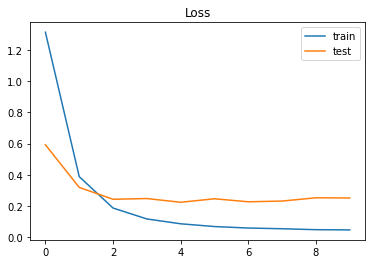

In [16]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

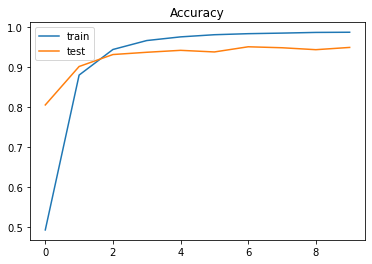

In [17]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [18]:
model2 = Sequential()
model2.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model2.add(SpatialDropout1D(0.2))
model2.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model2.add(Dense(47, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 25, 100)           500000    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 25, 100)          0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 47)                4747      
                                                                 
Total params: 585,147
Trainable params: 585,147
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
epochs = 10
batch_size = 64

history = model2.fit(X_train_2, Y_train_2, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Epoch 1/10
174/174 [==============================] - 48s 263ms/step - loss: 3.0490 - accuracy: 0.1959 - val_loss: 2.7272 - val_accuracy: 0.3040
Epoch 2/10
174/174 [==============================] - 47s 271ms/step - loss: 2.1278 - accuracy: 0.4568 - val_loss: 1.5266 - val_accuracy: 0.6370
Epoch 3/10
174/174 [==============================] - 46s 267ms/step - loss: 1.0581 - accuracy: 0.7519 - val_loss: 0.9094 - val_accuracy: 0.7842
Epoch 4/10
174/174 [==============================] - 48s 278ms/step - loss: 0.5783 - accuracy: 0.8724 - val_loss: 0.6431 - val_accuracy: 0.8480
Epoch 5/10
174/174 [==============================] - 48s 273ms/step - loss: 0.3629 - accuracy: 0.9221 - val_loss: 0.5147 - val_accuracy: 0.8852
Epoch 6/10
174/174 [==============================] - 48s 274ms/step - loss: 0.2552 - accuracy: 0.9491 - val_loss: 0.4540 - val_accuracy: 0.9038
Epoch 7/10
174/174 [==============================] - 47s 271ms/step - loss: 0.1882 - accuracy: 0.9644 - val_loss: 0.4259 - val_ac

In [20]:
accr = model2.evaluate(X_test_2,Y_test_2)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

97/97 [==============================] - 4s 38ms/step - loss: 0.3935 - accuracy: 0.9282
Test set
  Loss: 0.394
  Accuracy: 0.928


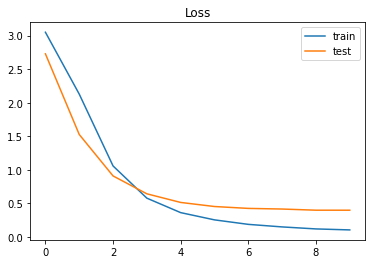

In [21]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

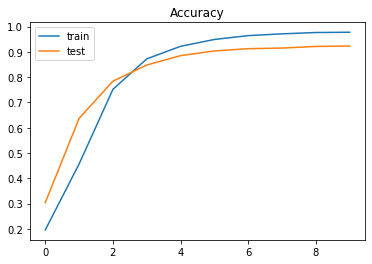

In [22]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();